# Import modules

In [1]:
import glob
import os.path
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import yasa

plt.style.use('default')
plt.rc('font', family='Arial')
plt.rc('font', size=14)
plt.rc('axes', unicode_minus=False)

mne.set_log_level('CRITICAL')

# Import data and preprocessing

In [2]:
import dataset

path_data = dataset.data_path
files = glob.glob(os.path.join(path_data, '**', 'raw_clean.fif'), recursive=True)

In [3]:
df_info = pd.read_excel('info.xlsx', index_col=0)

In [4]:
typical_traces = []

df_power_epochs = pd.DataFrame()

for file in files:
    animal, session = np.array(file.split('\\'))[[-3, -2]]
    
    group = df_info.loc[animal, 'Genotype']
    
    raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
    raw._data[np.isnan(raw._data)] = 0

    epochs = mne.make_fixed_length_epochs(raw, duration=3, preload=True)
    epochs.drop_bad(flat=dict(eeg=5e-6), reject={'bio': 25e-6, 'eeg': 120e-6})

    if len(epochs)==0:
        continue

    power_epochs = epochs.compute_psd()
    freqs = power_epochs.freqs
    band_power = pd.DataFrame()
    for power_epoch in power_epochs:
        power = power_epoch.squeeze()

        df = yasa.bandpower_from_psd(power, freqs, relative=False)
        band_power = pd.concat([band_power, df])
    
    band_power['Animal'] = animal
    band_power['Genotype'] = group
    df_power_epochs = pd.concat([df_power_epochs, band_power])
    
    if group == 'WT':
    
        idx_max_delta = np.argmin(band_power['Delta'])
    else:
        idx_max_delta = np.argmax(band_power['Delta'])
        
    typical_trace = epochs[idx_max_delta].copy().pick('eeg').get_data(units='uV').squeeze()
    typical_traces.append((animal, typical_trace))

    # plt.plot(epochs.times, typical_trace)
    # plt.show()

C:\Users\HP\AppData\Local\Temp\ipykernel_8164\2178596409.py:10: RuntimeWarning: This filename (C:\Users\HP\PycharmProjects\as_monkey_eeg\X8_data\0628#\2024-03-14\raw_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
C:\Users\HP\AppData\Local\Temp\ipykernel_8164\2178596409.py:10: RuntimeWarning: This filename (C:\Users\HP\PycharmProjects\as_monkey_eeg\X8_data\0628#\2024-03-24\raw_clean.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, _meg.fif, _eeg.fif, _ieeg.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz, _meg.fif.gz, _eeg.fif.gz or _ieeg.fif.gz
  raw = mne.io.read_raw_fif(file, preload=True, verbose=False)
C:\Users\HP\AppData\Local\Temp\ipykernel_8164\2178596409.py:10: Ru

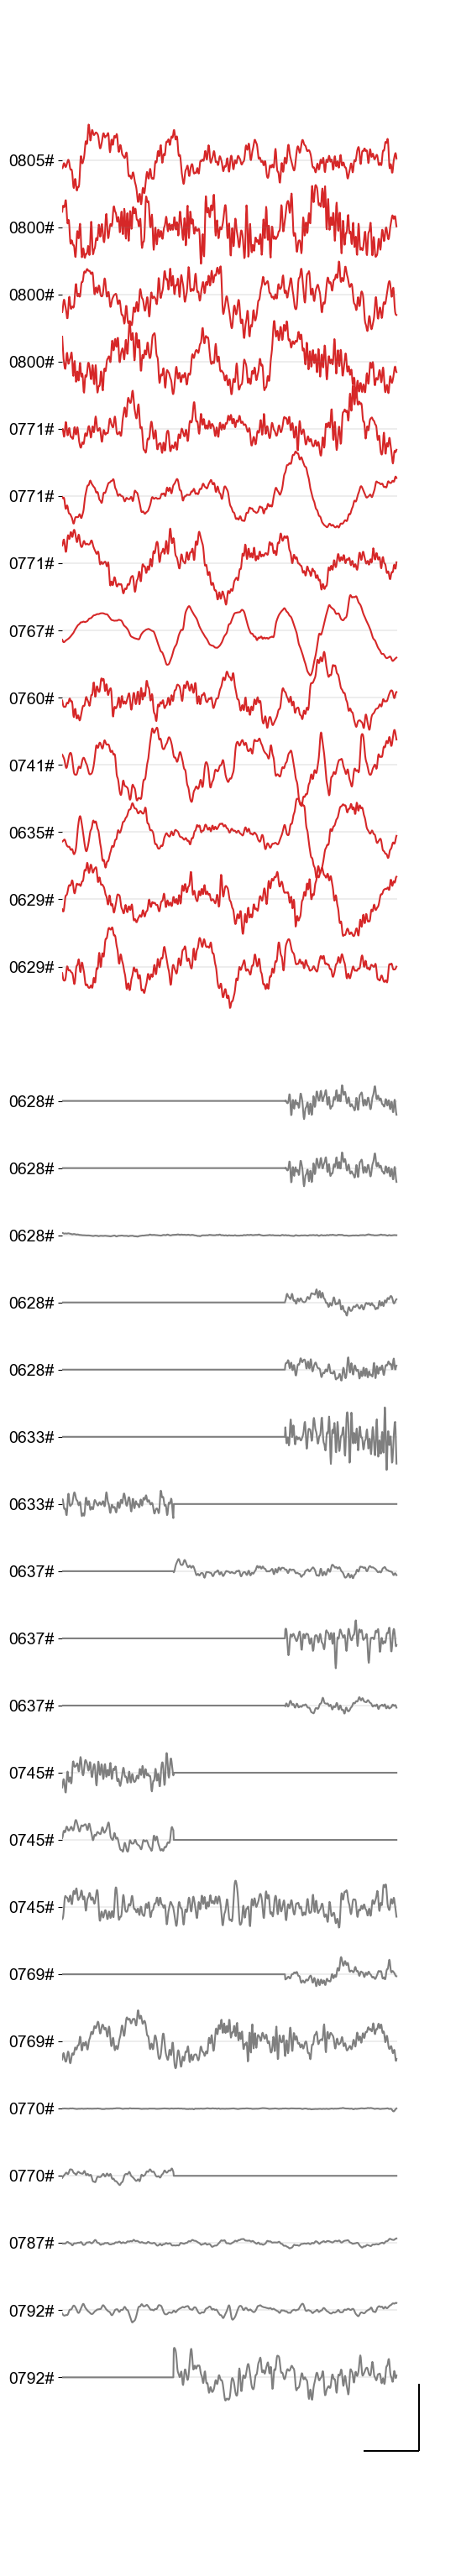

In [5]:


row_upper = 0
row_lower = 0
offset= 100

color_map = {
    'Mutant': 'tab:red',
    'WT': 'tab:grey',
}

ticks = []
ticklabels = []

l = {}

plt.figure(figsize=(6, len(typical_traces)*1.2))

for animal, trace in typical_traces:
    group = df_info.loc[animal, 'Genotype']
    if  group == 'Mutant':
        row_upper+=1
        row = row_upper
    else:
        row_lower-=1
        row = row_lower
        
    ticks.append(offset * row)
    ticklabels.append(animal)
    
    
    l[df_info.loc[animal, 'Genotype']] = plt.plot(epochs.times, trace + offset * row, label=animal, color=color_map[group])
    plt.hlines(offset * row, 0, 3, colors='grey', linewidth=0.2)

ruler_shift = (0.2, offset*1.1)

plt.hlines(min(ticks)-ruler_shift[1], 2.5 + ruler_shift[0], 3+ruler_shift[0], colors='k')

plt.vlines(3+ruler_shift[0], min(ticks)-ruler_shift[1], min(ticks)-ruler_shift[1] + 100, colors='k')
# plt.text(2.8,min(ticks)-offset*1.9,'0.5s')
plt.gca().set(frame_on=False)
plt.yticks(ticks, labels=ticklabels)
# plt.grid(axis='y')
plt.xlim(0, 3.5)
plt.gca().axes.get_xaxis().set_visible(False)




In [6]:
df_power_epochs_plot = df_power_epochs.copy()
df_power_epochs_plot['Delta'] = 1e9*df_power_epochs_plot['Delta']

Text(0, 0.5, 'Percent')

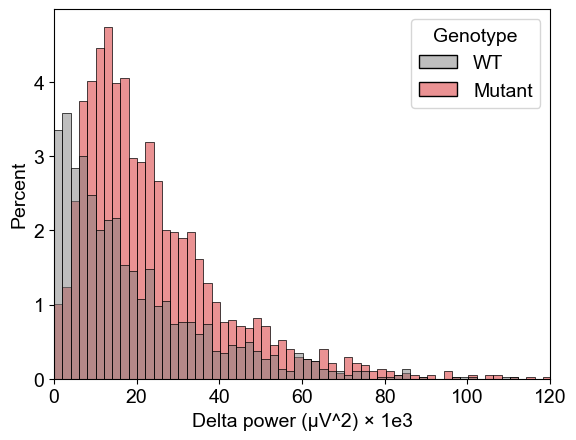

In [7]:
import seaborn as sns

sns.histplot(data = df_power_epochs_plot, x='Delta', hue='Genotype', palette=['tab:gray', 'tab:red'], hue_order=['WT', 'Mutant'], binwidth=2, stat='percent')
plt.xlabel('Delta power (μV^2) × 1e3')
plt.xlim(0, 120)
plt.ylabel('Percent')